# 1. Processar Dados para Extrair Padrões

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
%matplotlib inline
df = pd.read_csv('../crime_segunda_area.csv')

# Análise Exploratória (EDA)

In [2]:
display(df)

,latitude,longitude,data,hora,tipo_crime,bairro,rua,tipo_dia,ano,nome,cpf,idade,email,telefone,endereco,risco,__ERRO__,null
0,-15.818464,-47.904276,2022-10-15,19:35,tráfico,Asa Sul,W3 Sul,final_semana,2022,Laís Jesus,714.280.539-05,16.0,cassianomiguel@example.com,31 4922 2888,NaN,4,ERRO_404,NaN
1,-15.838468,-47.918406,2022-07-02,08:06,tráfico,Asa Sul,L2 Sul,final_semana,2022,Brayan da Mata,210.679.345-61,24.0,mda-cunha@example.com,+55 (041) 7595 3532,"L2 Sul Edifício Center, Unidade 232",5,ERRO_404,NaN
2,-15.817930,-47.908504,2022-05-04,23:34,roubo,Asa Sul,Novo Setor 1,dia_normal,2022,Mathias Vargas,143.079.528-04,20.0,gferreira@example.net,NaN,"Novo Setor 1 Bloco C, Ap 434",3,ERRO_404,NaN
3,-15.801835,-47.885813,2020-05-29,00:31,furto,Asa Sul,Novo Setor 1,final_semana,2020,Luiz Gustavo Fogaça,837.549.102-05,26.0,santosgabriela@example.net,+55 (084) 2009 2395,"Novo Setor 1 Bloco A, Ap 717",3,ERRO_404,NaN
4,-15.821958,-47.899781,2021-11-06,23:38,furto,Asa Sul,Novo Setor 1,final_semana,2021,Murilo Fernandes,698.705.241-76,25.0,uda-cruz@example.org,+55 31 1729-6758,"Novo Setor 1 Lote 10, Sala 296",3,ERRO_404,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-15.804922,-47.898995,2024-10-06,02:21,homicídio,Asa Sul,W3 Sul,dia_normal,2024,Natália Araújo,420.367.189-22,NaN,almeidaheitor@example.org,+55 (011) 4663-2550,"W3 Sul Lote 20, Sala 123",4,ERRO_404,NaN
29996,-15.821369,-47.910746,2020-04-14,18:36,furto,Asa Sul,Eixo L Sul,dia_normal,2020,Maria Helena Vargas,541.306.927-80,70.0,daniel66@example.net,(051) 0240-5238,"Eixo L Sul Bloco A, Ap 138",2,ERRO_404,NaN
29997,-15.811201,-47.888102,2022-12-23,08:20,vandalismo,Asa Sul,Novo Setor 1,final_semana,2022,Rael Melo,473.809.621-40,18.0,barrosalexia@example.org,0900-508-1195,"Novo Setor 1 Bloco D, Ap 993",3,ERRO_404,NaN
29998,-15.821519,-47.909349,2023-05-18,23:09,NaN,Asa Sul,Eixo L Sul,dia_normal,2023,Ravi Lucca Campos,265.841.793-46,67.0,ayla21@example.net,0500-477-3218,"Eixo L Sul Lote 9, Sala 219",2,ERRO_404,NaN


### Inspeção inicial

In [3]:
print(f"Dimensões do DataFrame\n\n{df.shape}")
print("\nHEAD\n",df.head())
print("\nDESCRIBE\n",df.describe(include="all"))

Dimensões do DataFrame

(30000, 18)

HEAD
     latitude  longitude        data   hora tipo_crime   bairro           rua  \
0 -15.818464 -47.904276  2022-10-15  19:35    tráfico  Asa Sul        W3 Sul   
1 -15.838468 -47.918406  2022-07-02  08:06    tráfico  Asa Sul        L2 Sul   
2 -15.817930 -47.908504  2022-05-04  23:34      roubo  Asa Sul  Novo Setor 1   
3 -15.801835 -47.885813  2020-05-29  00:31      furto  Asa Sul  Novo Setor 1   
4 -15.821958 -47.899781  2021-11-06  23:38      furto  Asa Sul  Novo Setor 1   

       tipo_dia   ano                 nome             cpf  idade  \
0  final_semana  2022           Laís Jesus  714.280.539-05   16.0   
1  final_semana  2022       Brayan da Mata  210.679.345-61   24.0   
2    dia_normal  2022       Mathias Vargas  143.079.528-04   20.0   
3  final_semana  2020  Luiz Gustavo Fogaça  837.549.102-05   26.0   
4  final_semana  2021     Murilo Fernandes  698.705.241-76   25.0   

                        email             telefone  \
0  cass

### Verificando dados Nulos e duplicatas

In [4]:
#Nulos
print(df.isnull().sum())
#Duplicatas
print("---------------------\n        Duplicatas")
print("Duplicatas:", df.duplicated().sum())

latitude          0
longitude         0
data              0
hora              0
tipo_crime      279
bairro            0
rua               0
tipo_dia          0
ano               0
nome            932
cpf               0
idade          2394
email          6010
telefone       2050
endereco       2618
risco             0
__ERRO__          0
null          30000
dtype: int64
---------------------
        Duplicatas
Duplicatas: 0


## Visualização de Dados

## a) Crimes por Horário


In [5]:

# Contar crimes por hora
df['hora'] = pd.to_datetime(df['hora']).dt.hour
crimes_por_hora = df.groupby('hora').size().reset_index(name='contagem')
crimes_por_hora = crimes_por_hora.sort_values(by='contagem', ascending=False)
print("Horários com mais crimes:")
print(crimes_por_hora.head(24))

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\2489483636.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hora'] = pd.to_datetime(df['hora']).dt.hour


Horários com mais crimes:
    hora  contagem
22    22      2368
0      0      2353
23    23      2345
21    21      2326
20    20      2133
1      1      2124
2      2      1857
19    19      1826
3      3      1606
18    18      1545
4      4      1361
17    17      1304
5      5      1077
16    16       988
15    15       820
6      6       762
14    14       615
7      7       573
13    13       447
8      8       417
12    12       321
9      9       320
10    10       267
11    11       245


### Gráfico quantidade de Crimes Por Hora

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\2643618714.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crimes_por_hora.index, y=crimes_por_hora.values, palette=colors)


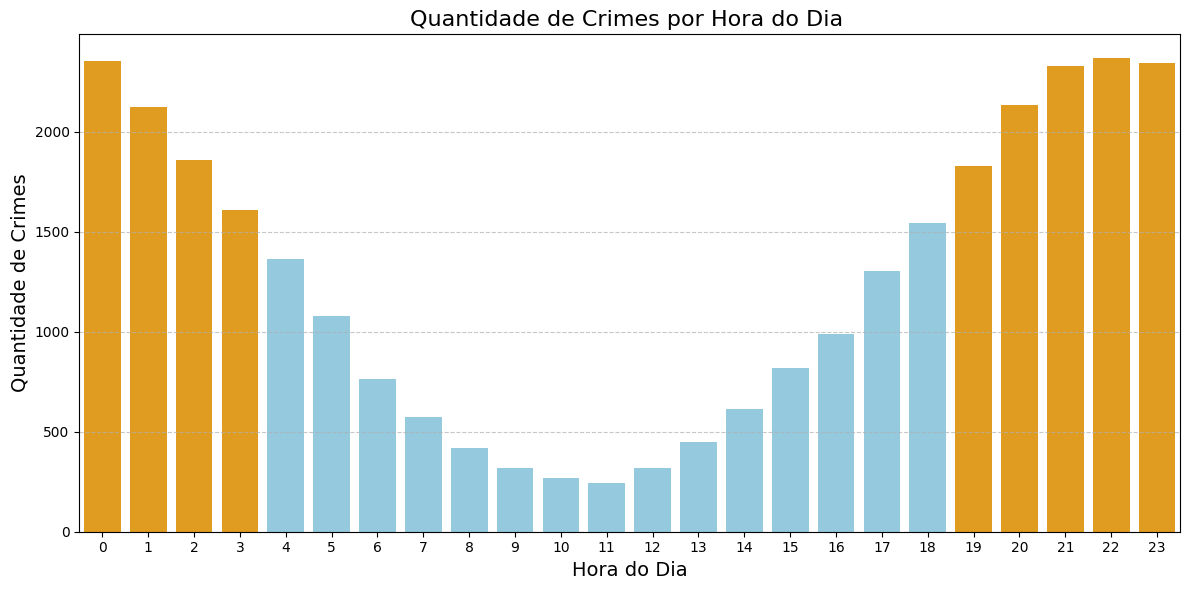

In [6]:

# Contar quantos crimes ocorreram em cada hora
crimes_por_hora = df['hora'].value_counts().sort_index()
# Definir cores para destacar 21h–23h e 0h–2h
colors = ['orange' if h >= 19 or h < 4 else 'skyblue' for h in crimes_por_hora.index]

# Plotar com cores personalizadas
plt.figure(figsize=(12, 6))
sns.barplot(x=crimes_por_hora.index, y=crimes_por_hora.values, palette=colors)
plt.title("Quantidade de Crimes por Hora do Dia ", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=14)
plt.ylabel("Quantidade de Crimes", fontsize=14)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## b) Crimes por Localização


In [7]:
# Contar crimes por rua
crimes_por_rua = df.groupby('rua').size().reset_index(name='contagem')
crimes_por_rua = crimes_por_rua.sort_values(by='contagem', ascending=False)
print("Ruas com mais crimes:")
print(crimes_por_rua.head(3))

Ruas com mais crimes:
            rua  contagem
0    Eixo L Sul     10405
3        W3 Sul      7984
2  Novo Setor 1      7100


### Gráfico crime por localidade

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\2587393700.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='contagem', y='rua', data=top_ruas, palette='viridis')


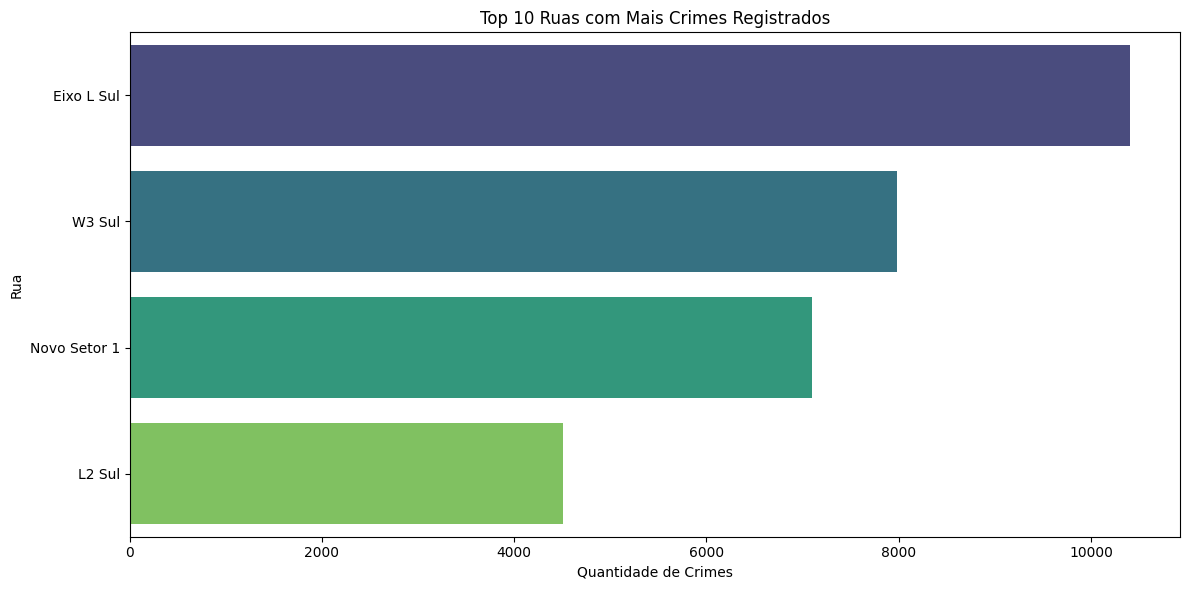

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seu código para agrupar os dados
crimes_por_rua = df.groupby('rua').size().reset_index(name='contagem')
crimes_por_rua = crimes_por_rua.sort_values(by='contagem', ascending=False)

# Mostrar top 10 ruas com mais crimes (ajuste conforme necessário)
top_ruas = crimes_por_rua.head(10)

# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='contagem', y='rua', data=top_ruas, palette='viridis')

# Configurações do gráfico
plt.title('Top 10 Ruas com Mais Crimes Registrados')
plt.xlabel('Quantidade de Crimes')
plt.ylabel('Rua')
plt.tight_layout()

# Mostrar gráfico
plt.show()

##    c) Crimes por Tipo


In [9]:
# Contar crimes por tipo
crimes_por_tipo = df.groupby('tipo_crime').size().reset_index(name='contagem')
crimes_por_tipo = crimes_por_tipo.sort_values(by='contagem', ascending=False)
print("Tipos de crime mais comuns:")
print(crimes_por_tipo.head(3))

Tipos de crime mais comuns:
   tipo_crime  contagem
1       furto      8594
3       roubo      5936
5  vandalismo      5460


### Gráfico de Tipos de Crime


Quantidade total de crimes:

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\3331100647.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=frequencia_crimes_total, x='quantidade', y='tipo_crime', palette='viridis')


 30000

Principais tipos de crimes:
    tipo_crime  quantidade  porcentagem
0        furto        8594    28.915582
1        roubo        5936    19.972410
2   vandalismo        5460    18.370849
3      tráfico        4877    16.409273
4    homicídio        3301    11.106625
5  feminicídio        1553     5.225262


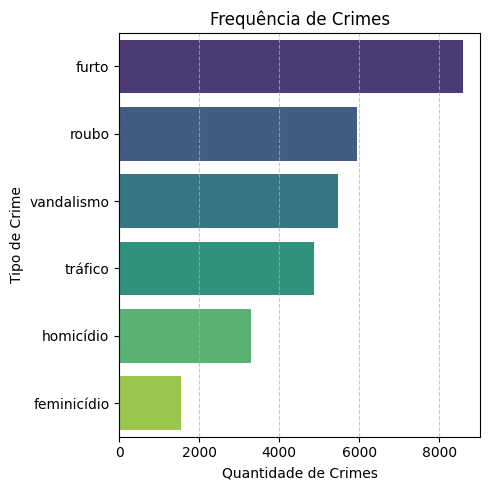

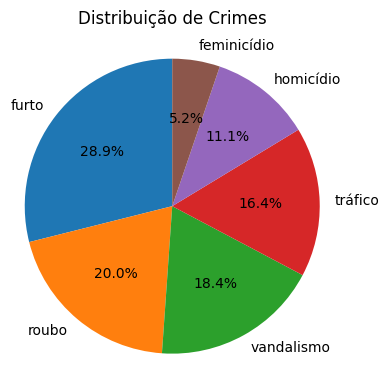

In [10]:
# Verificar se há registros
print("\nQuantidade total de crimes:", len(df))

# Contar frequência de cada tipo de crime noturno
frequencia_crimes_total = df['tipo_crime'].value_counts().reset_index()
frequencia_crimes_total.columns = ['tipo_crime', 'quantidade']

# Calcular porcentagem
total_crimes = frequencia_crimes_total['quantidade'].sum()
frequencia_crimes_total['porcentagem'] = (frequencia_crimes_total['quantidade'] / total_crimes) * 100

# Exibir resultados
print("\nPrincipais tipos de crimes:")
print(frequencia_crimes_total)

# Gráfico de barras
plt.figure(figsize=(5, 5))
sns.barplot(data=frequencia_crimes_total, x='quantidade', y='tipo_crime', palette='viridis')
plt.title('Frequência de Crimes')
plt.xlabel('Quantidade de Crimes')
plt.ylabel('Tipo de Crime')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(frequencia_crimes_total['quantidade'], labels=frequencia_crimes_total['tipo_crime'], autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Crimes')
plt.axis('equal')
plt.tight_layout()
plt.show()

#### Risco por regiao com base nos tipos de crime e rua


In [11]:
# Definir pesos por tipo de crime
pesos = {
    'feminicídio': 5,
    'homicídio': 5,
    'tráfico': 4,
    'roubo': 3,
    'furto': 2,
    'vandalismo': 1
}

# Adicionar coluna de peso
df['peso'] = df['tipo_crime'].map(pesos)

# Calcular pontuação de risco por rua
risco_por_rua = df.groupby('rua')['peso'].sum().reset_index(name='risco_total')
risco_por_rua = risco_por_rua.sort_values(by='risco_total', ascending=False)
print("Ruas com maior risco:")
print(risco_por_rua.head(3))

Ruas com maior risco:
            rua  risco_total
3        W3 Sul      27507.0
0    Eixo L Sul      23161.0
2  Novo Setor 1      20624.0


#### Identificando Horários de Risco com crimes de mais gravidade e horários


In [12]:
# Filtrar crimes graves (ex: homicídio, tráfico)
crimes_graves = df[df['tipo_crime'].isin(['homicídio', 'tráfico'])]

# Contar crimes graves por hora
horarios_risco = crimes_graves.groupby('hora').size().reset_index(name='contagem')
horarios_risco = horarios_risco.sort_values(by='contagem', ascending=False)
print("Horários com mais crimes graves:")
print(horarios_risco.head(3))

Horários com mais crimes graves:
    hora  contagem
23    23       644
0      0       643
21    21       627


### Gráfico de crimes noturnos( entre 21h as 4)


Quantidade total de crimes: 30000
Quantidade de crimes noturnos: 20299

Principais tipos de crimes noturnos:
    tipo_crime  quantidade  porcentagem
0        furto        5790    28.811704
1        roubo        3994    19.874602
2   vandalismo        3667    18.247412
3      tráfico        3349    16.665008
4    homicídio        2196    10.927548
5  feminicídio        1100     5.473726


C:\Users\migue\AppData\Local\Temp\ipykernel_66004\370515097.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=frequencia_crimes, x='quantidade', y='tipo_crime', palette='viridis')


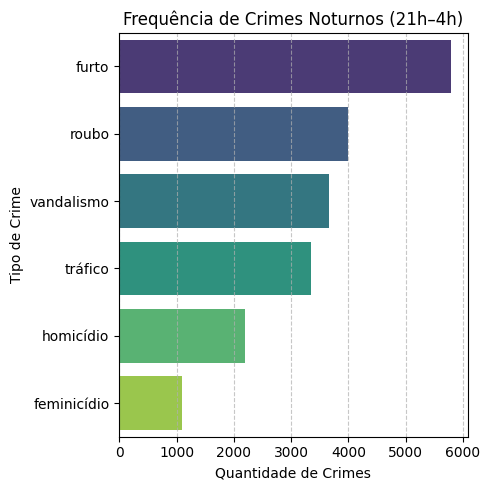

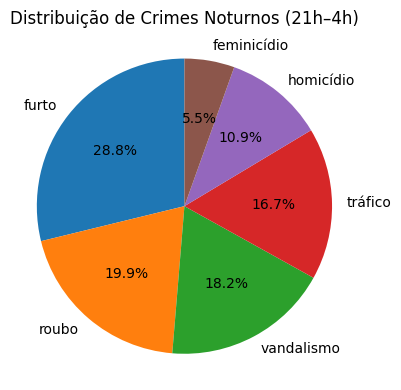

In [13]:

# Filtrar crimes noturnos (21h–23h e 00h–5h)
crimes_noturnos = df[(df['hora'] >= 19) | (df['hora'] <= 4)]

# Verificar se há registros noturnos
print("\nQuantidade total de crimes:", len(df))
print("Quantidade de crimes noturnos:", len(crimes_noturnos))

# Contar frequência de cada tipo de crime noturno
frequencia_crimes = crimes_noturnos['tipo_crime'].value_counts().reset_index()
frequencia_crimes.columns = ['tipo_crime', 'quantidade']

# Calcular porcentagem
total_crimes_noturnos = frequencia_crimes['quantidade'].sum()
frequencia_crimes['porcentagem'] = (frequencia_crimes['quantidade'] / total_crimes_noturnos) * 100

# Exibir resultados
print("\nPrincipais tipos de crimes noturnos:")
print(frequencia_crimes)

# Gráfico de barras
plt.figure(figsize=(5, 5))
sns.barplot(data=frequencia_crimes, x='quantidade', y='tipo_crime', palette='viridis')
plt.title('Frequência de Crimes Noturnos (21h–4h)')
plt.xlabel('Quantidade de Crimes')
plt.ylabel('Tipo de Crime')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(frequencia_crimes['quantidade'], labels=frequencia_crimes['tipo_crime'], autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Crimes Noturnos (21h–4h)')
plt.axis('equal')  # Para manter o círculo redondo
plt.tight_layout()
plt.show()

## Vitimas Por Idade

### Gráficos de vitimas de crime por idade 

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\640978022.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=frequencia_idades, x='quantidade', y='faixa_etaria', palette='viridis')


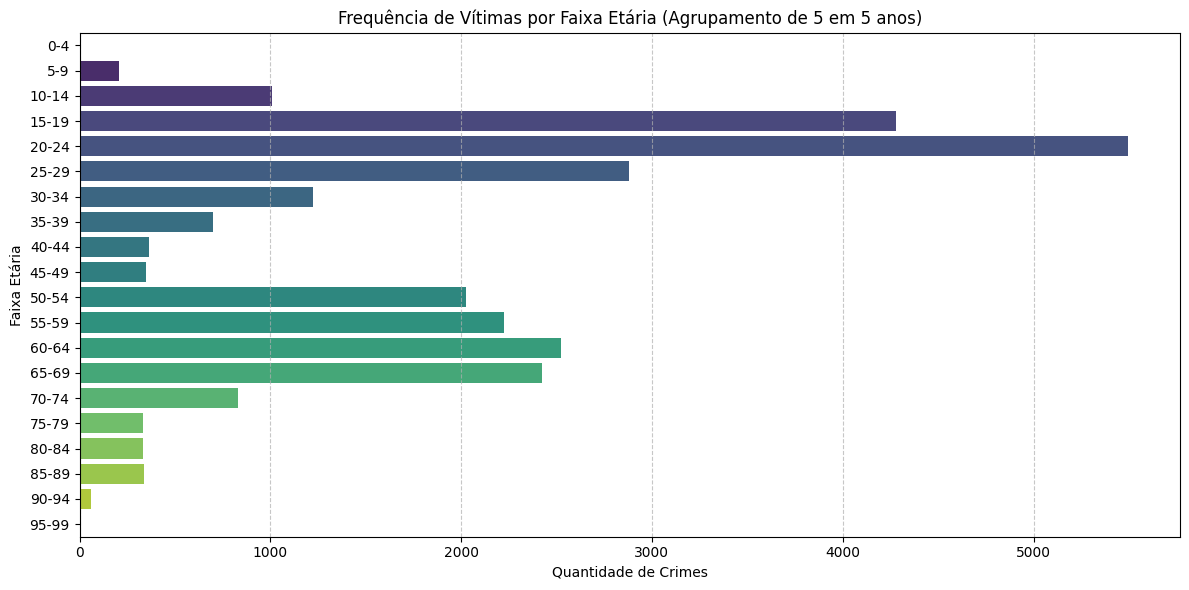

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Limpar NaN e converter idade para inteiro
df_idade = df['idade'].dropna().astype(int)

# Definir intervalos de 5 anos
bins = range(0, 101, 5)  # 0-5, 5-10, 10-15, ..., 95-100
labels = [f"{i}-{i+4}" for i in bins[:-1]]

# Agrupar idades
binned_ages = pd.cut(df_idade, bins=bins, labels=labels, right=False)

# Contar frequência por grupo de idade
frequencia_idades = binned_ages.value_counts().sort_index()
frequencia_idades = frequencia_idades.reset_index()
frequencia_idades.columns = ['faixa_etaria', 'quantidade']

# Calcular porcentagem
total = frequencia_idades['quantidade'].sum()
frequencia_idades['porcentagem'] = (frequencia_idades['quantidade'] / total) * 100

# Plotar gráfico de barras
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=frequencia_idades, x='quantidade', y='faixa_etaria', palette='viridis')
plt.title("Frequência de Vítimas por Faixa Etária (Agrupamento de 5 em 5 anos)")
plt.xlabel("Quantidade de Crimes")
plt.ylabel("Faixa Etária")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Mapa de Correlação

In [15]:
from scipy.stats import f_oneway
import numpy as np

def correlation_ratio(categories, measurements):
    # Garantir que measurements seja numérico
    measurements = pd.to_numeric(measurements, errors='coerce')
    
    # Remover valores nulos
    valid_idx = ~np.isnan(measurements)
    categories = categories[valid_idx]
    measurements = measurements[valid_idx]
    
    # Agrupar idades por tipo de crime
    groups = [measurements[categories == c] for c in np.unique(categories)]
    
    # Verificar se todos os grupos têm pelo menos uma amostra
    groups = [g for g in groups if len(g) > 0]
    
    if len(groups) < 2:
        return 0  # Não é possível calcular com apenas um grupo
    
    # Calcular F e variâncias
    f, _ = f_oneway(*groups)
    SS_total = np.sum((measurements - np.mean(measurements))**2)
    SS_between = np.sum([len(g) * (np.mean(g) - np.mean(measurements))**2 for g in groups])
    
    return SS_between / SS_total
# Garantir que idade seja numérica
df['idade'] = pd.to_numeric(df['idade'], errors='coerce')

# Alinhar categorias e medidas
df_clean = df[['tipo_crime', 'idade']].dropna()
categorias = df_clean['tipo_crime']
idades = df_clean['idade']

# Calcular correlation ratio
print("Correlation Ratio (idade vs tipo_crime):", correlation_ratio(categorias, idades))

Correlation Ratio (idade vs tipo_crime): 0.24030369225254658


In [16]:
from scipy.stats import chi2_contingency

# Calcular Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

print("Cramér’s V (tipo_crime vs rua):", cramers_v(df['tipo_crime'], df['rua']))

Cramér’s V (tipo_crime vs rua): 0.3093345766484096


In [17]:
# Função para calcular correlação entre qualquer par de colunas
def mixed_correlation(df):
    cols = df.columns
    result = pd.DataFrame(index=cols, columns=cols)
    
    for col1 in cols:
        for col2 in cols:
            if pd.api.types.is_numeric_dtype(df[col1]) and pd.api.types.is_numeric_dtype(df[col2]):
                # Correlação de Pearson
                result.loc[col1, col2] = df[[col1, col2]].corr().iloc[0, 1]
            elif (pd.api.types.is_categorical_dtype(df[col1]) or df[col1].dtype == 'object') and (pd.api.types.is_numeric_dtype(df[col2])):
                # Correlation Ratio (categórico vs numérico)
                result.loc[col1, col2] = correlation_ratio(df[col1], df[col2])
            elif (pd.api.types.is_numeric_dtype(df[col1])) and (pd.api.types.is_categorical_dtype(df[col2]) or df[col2].dtype == 'object'):
                # Correlation Ratio (numérico vs categórico)
                result.loc[col1, col2] = correlation_ratio(df[col2], df[col1])
            else:
                # Cramér’s V (categórico vs categórico)
                result.loc[col1, col2] = cramers_v(df[col1], df[col2])
    return result.astype(float)

C:\Users\migue\AppData\Local\Temp\ipykernel_66004\3080772362.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif (pd.api.types.is_categorical_dtype(df[col1]) or df[col1].dtype == 'object') and (pd.api.types.is_numeric_dtype(df[col2])):
C:\Users\migue\AppData\Local\Temp\ipykernel_66004\3080772362.py:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif (pd.api.types.is_numeric_dtype(df[col1])) and (pd.api.types.is_categorical_dtype(df[col2]) or df[col2].dtype == 'object'):
C:\Users\migue\AppData\Local\Temp\ipykernel_66004\3080772362.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif (pd.api.types.is_categorical_dtype(df[col1]) or df[col1].dtype == 'object') and (pd.api.

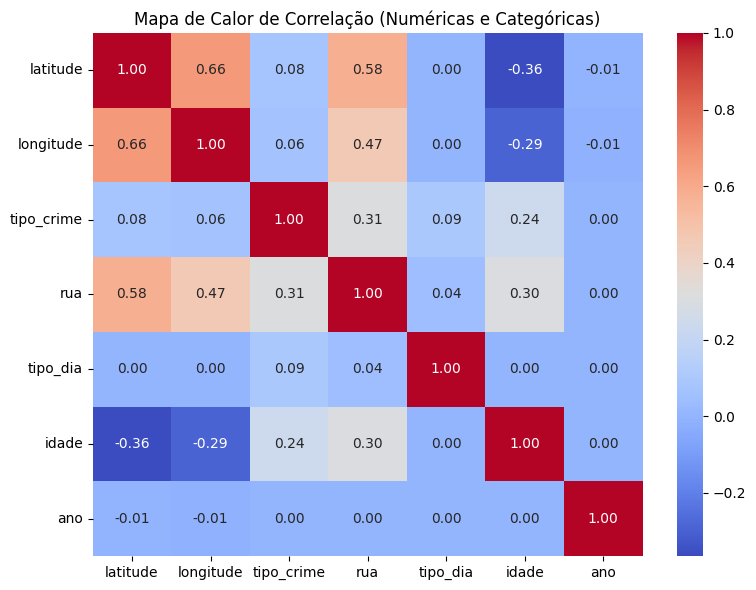

In [18]:
# Limpar dados
df_clean = df[["latitude","longitude",'tipo_crime', 'rua', 'tipo_dia', 'idade', 'ano']].dropna()

# Calcular correlação mista
mixed_corr = mixed_correlation(df_clean)

# Plotar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mixed_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor de Correlação (Numéricas e Categóricas)")
plt.tight_layout()
plt.show()

## Mapas Folium Para Visualizar o Mapa de calor de crimes por região


In [19]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster

# Carregar os dados
df = pd.read_csv('../crime_segunda_area.csv')

# Definir peso por tipo de crime
peso_crime = {
    'furto': 2,
    'roubo': 3,
    'vandalismo': 1,
    'tráfico': 4,
    'homicídio': 5,
    'feminicídio': 5
}
df['peso'] = df['tipo_crime'].map(peso_crime)

# Risco por rua
risco_por_rua = df.groupby('rua').agg(
    total_crimes=('tipo_crime', 'count'),
    risco_total=('peso', 'sum')
).reset_index()
risco_por_rua['risco_medio'] = risco_por_rua['risco_total'] / risco_por_rua['total_crimes']

# Mapa interativo com marcadores e heatmap
mapa = folium.Map(location=[-15.7942, -47.8825], zoom_start=14, tiles='CartoDB positron')

# Cluster de marcadores
marker_cluster = MarkerCluster().add_to(mapa)
for _, row in df.sample(n=500).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['rua']} - {row['tipo_crime']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)

# Heatmap (usar amostra menor para performance)
heat_data = [[row['latitude'], row['longitude']] for _, row in df.sample(n=500).iterrows()]
HeatMap(heat_data, radius=15, blur=20, max_zoom=16).add_to(mapa)

# Marcadores dos setores com mais risco
risco_top = risco_por_rua.sort_values(by='risco_total', ascending=False).head(5)
for _, row in risco_top.iterrows():
    # Filtrar coordenadas médias da rua
    lat_media = df[df['rua'] == row['rua']]['latitude'].mean()
    lon_media = df[df['rua'] == row['rua']]['longitude'].mean()
    
    # Validar coordenadas antes de adicionar ao mapa
    if pd.notna(lat_media) and pd.notna(lon_media):
        folium.Marker(
            location=[lat_media, lon_media],
            popup=f"{row['rua']} (Risco: {row['risco_total']})",
            icon=folium.Icon(color='darkred', icon='warning-sign')
        ).add_to(mapa)

# Salvar o mapa
mapa.save('mapa_calor.html')
print("✅ Mapa salvo como 'mapa_calor.html'")

✅ Mapa salvo como 'mapa_calor.html'


### Mapa de Calor incidência de crimes por hora

In [20]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster
from sklearn.cluster import DBSCAN

# Carregar os dados
df = pd.read_csv('../crime_segunda_area.csv')

# Converter hora para numérica (se ainda não estiver)
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M', errors='coerce').dt.hour

# Loop por cada hora do dia (0–23)
for hora in range(24):
    # Filtrar dados para a hora atual
    df_hora = df[df['hora'] == hora]
    
    # Agrupar pontos próximos usando DBSCAN (epsilon=0.005 graus ≈ 500 metros)
    coords = df_hora[['latitude', 'longitude']].values
    dbscan = DBSCAN(eps=0.005, min_samples=5).fit(coords)
    labels = dbscan.labels_
    
    # Calcular centroides dos clusters
    unique_labels = set(labels)
    clusters = []
    for label in unique_labels:
        if label == -1:
            continue  # Ignorar outliers
        cluster = coords[labels == label]
        centroid = (np.mean(cluster[:, 0]), np.mean(cluster[:, 1]))
        count = len(cluster)
        clusters.append({'centroid': centroid, 'count': count})
    
    # Selecionar os 3 clusters com mais crimes
    top_clusters = sorted(clusters, key=lambda x: -x['count'])[:3]
    
    # Criar mapa base
    mapa = folium.Map(location=[-15.7942, -47.8825], zoom_start=14, tiles='CartoDB positron')
    
    # Cluster de marcadores (amostra de 500 registros para performance)
    marker_cluster = MarkerCluster().add_to(mapa)
    for _, row in df_hora.sample(n=100).iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"{row['rua']} - {row['tipo_crime']}",
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(marker_cluster)
    
    # Heatmap com ponderação pelo 'peso' do crime (opcional)
    heat_data = [[row['latitude'], row['longitude']] for _, row in df_hora.iterrows()]
    HeatMap(heat_data, radius=15, blur=20, max_zoom=16).add_to(mapa)
    
    # Adicionar marcadores dos 3 clusters com maior incidência
    colors = ['darkred', 'orange', 'blue']
    for i, cluster in enumerate(top_clusters):
        lat, lon = cluster['centroid']
        count = cluster['count']
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=10,
            color=colors[i % 3],
            fill=True,
            fill_color=colors[i % 3],
            popup=f"Máximo de {count} crimes nesse ponto"
        ).add_to(mapa)
    
    # Adicionar legenda da hora
    folium.map.LayerControl('bottomleft').add_to(mapa)
    folium.Marker(
        location=[-15.7942, -47.8825],
        icon=folium.DivIcon(html=f'<div style="font-weight: bold; color: red;">{hora}h</div>')
    ).add_to(mapa)
    
    # Salvar mapa da hora atual
    filename = f'mapa_calor_{hora:02d}.html'
    mapa.save(filename)
    print(f"✅ Mapa da {hora}h salvo como '{filename}'")

✅ Mapa da 0h salvo como 'mapa_calor_00.html'
✅ Mapa da 1h salvo como 'mapa_calor_01.html'
✅ Mapa da 2h salvo como 'mapa_calor_02.html'
✅ Mapa da 3h salvo como 'mapa_calor_03.html'
✅ Mapa da 4h salvo como 'mapa_calor_04.html'
✅ Mapa da 5h salvo como 'mapa_calor_05.html'
✅ Mapa da 6h salvo como 'mapa_calor_06.html'
✅ Mapa da 7h salvo como 'mapa_calor_07.html'
✅ Mapa da 8h salvo como 'mapa_calor_08.html'
✅ Mapa da 9h salvo como 'mapa_calor_09.html'
✅ Mapa da 10h salvo como 'mapa_calor_10.html'
✅ Mapa da 11h salvo como 'mapa_calor_11.html'
✅ Mapa da 12h salvo como 'mapa_calor_12.html'
✅ Mapa da 13h salvo como 'mapa_calor_13.html'
✅ Mapa da 14h salvo como 'mapa_calor_14.html'
✅ Mapa da 15h salvo como 'mapa_calor_15.html'
✅ Mapa da 16h salvo como 'mapa_calor_16.html'
✅ Mapa da 17h salvo como 'mapa_calor_17.html'
✅ Mapa da 18h salvo como 'mapa_calor_18.html'
✅ Mapa da 19h salvo como 'mapa_calor_19.html'
✅ Mapa da 20h salvo como 'mapa_calor_20.html'
✅ Mapa da 21h salvo como 'mapa_calor_21.html

### Mapa de Calor Atualizado

In [21]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap, MarkerCluster

# Carregar os dados
df = pd.read_csv('../crime_segunda_area.csv')

# Definir peso por tipo de crime
peso_crime = {
    'furto': 2,
    'roubo': 3,
    'vandalismo': 1,
    'tráfico': 4,
    'homicídio': 5,
    'feminicídio': 5
}
df['peso'] = df['tipo_crime'].map(peso_crime)

# Risco por rua
risco_por_rua = df.groupby('rua').agg(
    total_crimes=('tipo_crime', 'count'),
    risco_total=('peso', 'sum')
).reset_index()
risco_por_rua['risco_medio'] = risco_por_rua['risco_total'] / risco_por_rua['total_crimes']

# Mapa interativo com marcadores e heatmap
mapa = folium.Map(location=[-15.7942, -47.8825], zoom_start=14, tiles='CartoDB positron')

# Cluster de marcadores
marker_cluster = MarkerCluster().add_to(mapa)
for _, row in df.sample(n=500).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['rua']} - {row['tipo_crime']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(marker_cluster)

# Heatmap (usar amostra menor para performance)
heat_data = [[row['latitude'], row['longitude']] for _, row in df.sample(n=500).iterrows()]
HeatMap(heat_data, radius=15, blur=20, max_zoom=16).add_to(mapa)

# Marcadores dos setores com mais risco
risco_top = risco_por_rua.sort_values(by='risco_total', ascending=False).head(5)
for _, row in risco_top.iterrows():
    # Filtrar coordenadas médias da rua
    lat_media = df[df['rua'] == row['rua']]['latitude'].mean()
    lon_media = df[df['rua'] == row['rua']]['longitude'].mean()
    
    # Validar coordenadas antes de adicionar ao mapa
    if pd.notna(lat_media) and pd.notna(lon_media):
        folium.Marker(
            location=[lat_media, lon_media],
            popup=f"{row['rua']} (Risco: {row['risco_total']})",
            icon=folium.Icon(color='darkred', icon='warning-sign')
        ).add_to(mapa)

# Salvar o mapa
mapa.save('mapa_calor.html')
print("✅ Mapa salvo como 'mapa_calor.html'")

✅ Mapa salvo como 'mapa_calor.html'


5. Exibir Rotas no Waze ou Google Maps


In [22]:
# Exemplo de URL para abrir no Waze
lat_destino = -15.7932
lon_destino = -47.8815
url_waze = f"https://waze.com/ul?ll={lat_destino}%2C{lon_destino}&navigate=yes"
print("🔗 Rota no Waze:", url_waze)

🔗 Rota no Waze: https://waze.com/ul?ll=-15.7932%2C-47.8815&navigate=yes


## Insights

--> Há dados nulos que precisam ser tratados

--> foi tratado os valores de hora que eram string para numérico

--> necessário tratar vários valores strings para que a IA seja eficaz

--> foi observado padrões pela análise exploratória, a principal correlação é Lat Long e tipo de crime

--> Horário influencia na quantidade de crime e tipo de crime

--> uma área é a mais perigosa, na quadra 108 Sul

--> A idade que mais sofreu crime foi de 14 anos aos 23 anos 

# Pré Processamento

### Retirando colunas de Erro e Null

In [23]:
df = df.drop(columns=["__ERRO__", "null"])
print(df)

        latitude  longitude        data   hora  tipo_crime   bairro  \
0     -15.818464 -47.904276  2022-10-15  19:35     tráfico  Asa Sul   
1     -15.838468 -47.918406  2022-07-02  08:06     tráfico  Asa Sul   
2     -15.817930 -47.908504  2022-05-04  23:34       roubo  Asa Sul   
3     -15.801835 -47.885813  2020-05-29  00:31       furto  Asa Sul   
4     -15.821958 -47.899781  2021-11-06  23:38       furto  Asa Sul   
...          ...        ...         ...    ...         ...      ...   
29995 -15.804922 -47.898995  2024-10-06  02:21   homicídio  Asa Sul   
29996 -15.821369 -47.910746  2020-04-14  18:36       furto  Asa Sul   
29997 -15.811201 -47.888102  2022-12-23  08:20  vandalismo  Asa Sul   
29998 -15.821519 -47.909349  2023-05-18  23:09         NaN  Asa Sul   
29999 -15.802213 -47.896568  2020-07-09  21:37       roubo  Asa Sul   

                rua      tipo_dia   ano                 nome             cpf  \
0            W3 Sul  final_semana  2022           Laís Jesus  714.2

### Tratamento de Valores Nulos

In [24]:
print(df.isnull().sum())

# Tratamento para Tipo de crime, corresponde a ~1% de valores nulos, preencher com a moda
df['tipo_crime'] = df['tipo_crime'].fillna(df['tipo_crime'].mode()[0])
# Nome é um dado que não é necessário para a inteligência Artificial 
#Idade Irá ser preenchida com a Mediana
df['idade'] = df['idade'].fillna(df['idade'].mode()[0])
# email e telefone nao é uma informação importante para nós
#o endereço em si não é tão importante pois temos os dados de long lat,
#é possivel tratar indentificando qual o endereço mas a princípio não é o principal
print("---------------------------------\n     Dados Após o Tratamento\n")
print(df.isnull().sum())

latitude         0
longitude        0
data             0
hora             0
tipo_crime     279
bairro           0
rua              0
tipo_dia         0
ano              0
nome           932
cpf              0
idade         2394
email         6010
telefone      2050
endereco      2618
risco            0
peso           279
dtype: int64
---------------------------------
     Dados Após o Tratamento

latitude         0
longitude        0
data             0
hora             0
tipo_crime       0
bairro           0
rua              0
tipo_dia         0
ano              0
nome           932
cpf              0
idade            0
email         6010
telefone      2050
endereco      2618
risco            0
peso           279
dtype: int64
